## This is a notebook to calculate an optimal pub crawl route and plot it

First define some useful functions and input pub locations:

In [ ]:
#Directions API key
key = 'ENTER KEY HERE'

import requests
import matplotlib.pyplot as plt
import polyline
import numpy as np

def getTravelTime(orig, dest):
    r = requests.get('https://maps.googleapis.com/maps/api/directions/json?origin='
                     + orig + '&destination=' + dest + '&mode=transit&key=' + key)

    data = r.json()

    routes = data['routes']
    Nroutes = len(routes)
    routetouse = 0
    route = routes[routetouse]
    leg = route['legs'][0]

    steps = leg['steps']

    print('Found ' + str(Nroutes) + ' route(s)')
    print('Route 1 has ' + str(len(steps)) + ' steps')

    lat = np.zeros(len(steps))
    lon = np.zeros(len(steps))

    for i, step in enumerate(steps):
        lat[i] = step['start_location']['lat']
        lon[i] = step['start_location']['lng']
        print(step['html_instructions'])

    return leg['duration']['value'], lat, lon, data

def plotRoute(data, ax):
    steps = data['routes'][0]['legs'][0]['steps']

    for step in steps:
        pline = np.array(polyline.decode(step['polyline']['points']))
        if 'transit_details' in step:
            busname = step['transit_details']['line']['short_name']
            ax.text(np.mean(pline[:,1]), np.mean(pline[:,0]), busname, style='italic',horizontalalignment='center', color=[.1,0,.5])
            ax.plot(pline[:,1], pline[:,0], '--')
        else:
            ax.plot(pline[:,1], pline[:,0])
            
def plotPubs(ax):
    offset = 1.5e-4
    for place, pub in zip(places, pubnames):
        lat = alldata[place][place]['routes'][0]['legs'][0]['start_location']['lat']
        lon = alldata[place][place]['routes'][0]['legs'][0]['start_location']['lng']
        ax.text(lon+offset, lat+offset, pub)
        ax.plot(lon, lat, 'o', c='black',markerfacecolor='red')
    
def getTravelTimeMatrix(places):
    Nplaces = len(places)
    ttmatrix = np.zeros((Nplaces, Nplaces))

    alldata = dict()

    for i, orig in enumerate(places):
        for j, dest in enumerate(places):
            if j >= i:
                print('Planning from ' + places[i] + ' to ' + places[j])
                dur, lat, lon, data = getTravelTime(places[i], places[j])
                ttmatrix[i,j] = dur

                if places[i] not in alldata:
                    alldata[places[i]] = dict()

                alldata[places[i]][places[j]] = data
    
    return ttmatrix, alldata

def doTSP(tmatrix):
    tmatrix = tmatrix + tmatrix.T
    Nplaces = tmatrix.shape[0]

    tspstr = 'NAME: output\n\
    COMMENT: TSP\n\
    TYPE: TSP\n\
    DIMENSION: ' + str(Nplaces) + '\n\
    EDGE_WEIGHT_FORMAT: FULL_MATRIX\n\
    EDGE_WEIGHT_TYPE: EXPLICIT\n\
    EDGE_WEIGHT_SECTION\n'

    with open('TSPInput.txt', 'w') as f:
        f.write(tspstr)
        for i in tmatrix:
            for j in i:
                f.write(str(j)[:-2] + ' ')
            f.write('\n')
        f.close()

    from subprocess import call
    call(["/path/to/concorde", "/path/to/TSPInput.txt"])

    with open('TSPInput.sol', 'r') as f:
        text = f.readlines()
        text = text[1:]
        stops = ''
        for t in text:
            stops += t[:-1]
        f.close()

    stops = stops.split(' ')
    stops = stops[:-1]

    fstops = np.zeros((Nplaces,1),dtype='int')
    for i,s in enumerate(stops):
        fstops[i] = int(s)
    return np.squeeze(fstops)

Now a list of pub locations and names

In [154]:
places = ['EC4A 2BU',
          'W1D 5BG',
          'WC2A 3HP',
          'WC1V 6BN',
          'WC2E 9EB',
          'WC2H 9BA',
          'W1D 3AJ',
          'EC1N 6SJ']

pubnames = ['Ye Olde Cheshire Cheese',
          'The French House',
          'The Ship Tavern',
          'Cittie of York',
          'The Lamb and Flag',
          'The Cross Keys',
          'The Dog and Duck',
          'Ye Olde Mitre']

Now get the travel times and solve the TSP problem, then plot the result and save it.

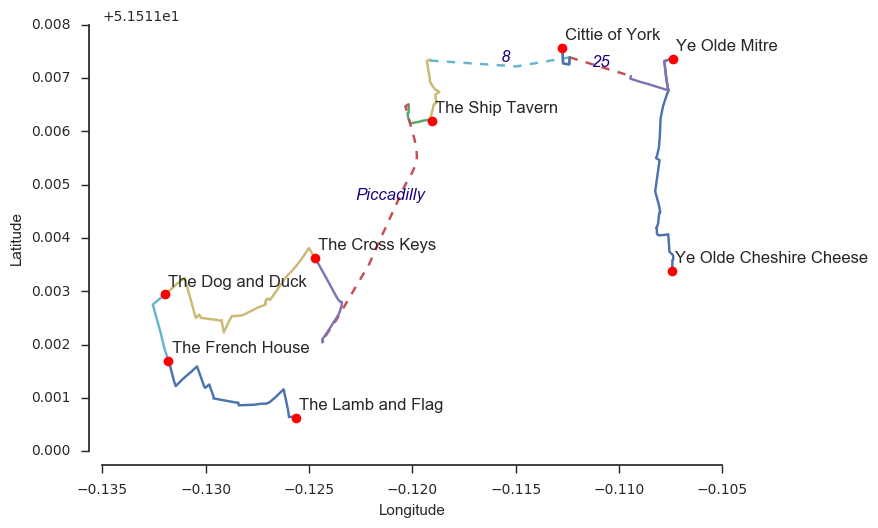

In [224]:
# This is slow
ttmatrix, alldata = getTravelTimeMatrix(places)

import seaborn as sns
sns.set_style('ticks')

route = doTSP(ttmatrix)

f,ax = plt.subplots(1,1)
for i in range(len(route)-1):
    inds = [route[i], route[i+1]]
    inds.sort()
    orig = places[inds[0]]
    dest = places[inds[1]]
    plotRoute(alldata[orig][dest],ax=ax)
    
plotPubs(ax)

sns.despine(offset=10, trim=True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('Route.png', bbox_inches='tight')
plt.show()

Plot the adjacency matrix and save a plot:

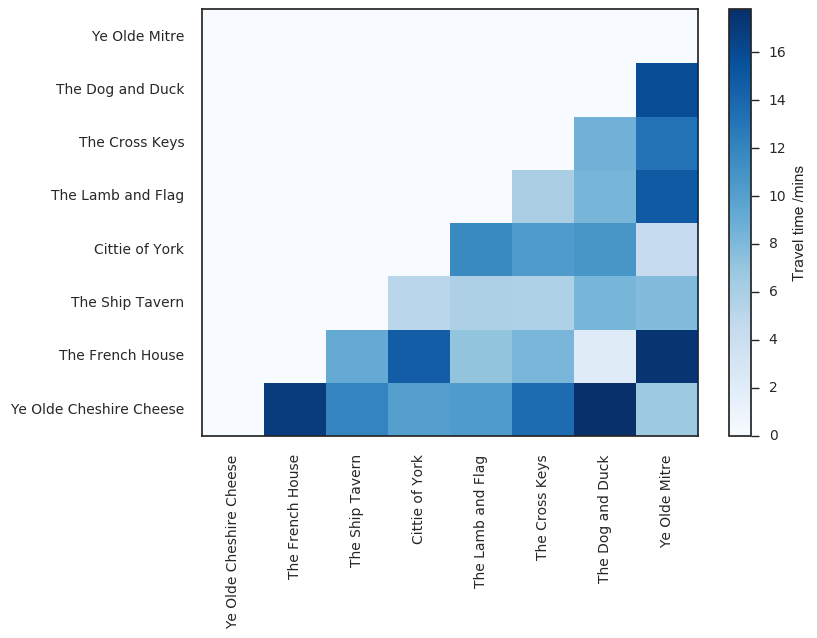

In [206]:
plt.pcolor(ttmatrix/60,cmap='Blues')
plt.xticks(np.linspace(1,8,8)-0.5, pubnames, rotation=90)
plt.yticks(np.linspace(1,8,8)-0.5, pubnames)
plt.tick_params('both', length=0, width=2, which='major')
plt.grid(linewidth=2)
plt.colorbar(label='Travel time /mins')
plt.show()